In [2]:
pip install reliability

Note: you may need to restart the kernel to use updated packages.
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=4cdc0fb50b6ab48a550438e00cd7f6e94b2c2740bde9f3b806ac0346ccfdf22e
  Stored in directory: c:\users\eleun\appdata\local\pip\cache\wheels\a8\03\64\8557323821d25118c3a2dc1646996f7a962a8970d4b7d22473
  Created wheel for mplcursors: filename=mplcursors-0.5.2-py3-none-any.whl size=21084 sha256=266917564a5cf7da47fd5faaaabcafed89705f4145992c5294ca16c6826e19c8
  Stored in directory: c:\users\eleun\appdata\local\pip\cache\wheels\b1\98\ff\4885c231adf3d185efdc38cf8aa2527f1b255ca714a43cb125
Successfully built autograd-gamma mplcursors
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3


In [21]:
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats

# Data Visualization
from matplotlib import pyplot as plt

# Reliability
from reliability.Fitters import Fit_Everything, Fit_Weibull_3P
from reliability.Reliability_testing import KStest
from reliability.Distributions import Weibull_Distribution, Lognormal_Distribution, Exponential_Distribution
from reliability.Probability_plotting import plot_points
from statsmodels.distributions.empirical_distribution import ECDF

# Utilities
import os
import numpy as np
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdmn

# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell

In [22]:
def sensitivity_analysis(dataframe, c_wins, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file',filepath, 'this may take a while...\n')
        tuples = []

        for win in c_wins:
            tup = 1
            prev = int(dataframe.loc[0,'Timestamp'])

            for index in range(dataframe.shape[0]-1):
                succ = int(dataframe.loc[index+1,'Timestamp'])
                if  succ - prev >= win:
                    tup = tup + 1
                prev = succ
  
            tuples.append(tup)
        
        df_sens = pd.DataFrame(data = {'Window' : c_wins, 'Tuples' : tuples})
        df_sens.to_csv(filepath)

    else:
        print('File already exists!\n')
        df_sens = pd.read_csv(filepath, index_col = 0)
    
    return df_sens   

In [23]:
def tupling(dataframe, c_win, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file', filepath, 'this may take a while...\n')
        
        tup = 0
        prev = int(dataframe.loc[0,'Timestamp'])
        dataframe.loc[0,'Tuple'] = 0

        for index in range(dataframe.shape[0]-1):
            succ = int(dataframe.loc[index+1,'Timestamp'])
            if  succ - prev >= c_win:
                tup = tup + 1
            dataframe.loc[index+1,'Tuple'] = tup
            prev = succ
            
        dataframe.to_csv(filepath)

    else:
        print('File already exists!\n')
        dataframe = pd.read_csv(filepath, index_col = 0)
    
    return dataframe


In [24]:
def statistics(dataframe):
    df_stat = pd.DataFrame(columns=['# Entries', 'Start time', 'End time', 'Length', 'Density', 'Interarrival'])

    df_stat['# Entries'] = dataframe.groupby(by='Tuple').count()['Timestamp']
    df_stat['Start time'] =  dataframe.groupby(by='Tuple').min(numeric_only = True)['Timestamp']
    df_stat['End time'] =  dataframe.groupby(by='Tuple').max(numeric_only = True)['Timestamp']
    df_stat['Length'] =  df_stat['End time'] - df_stat['Start time']
    df_stat['Density'] = df_stat['# Entries'] / df_stat['Length']
    df_temp = pd.DataFrame(data = {'Start time' : [np.nan]})
    df_temp = df_temp.append(df_stat, ignore_index = True)
    df_stat['Interarrival'] = (df_stat['Start time'] - df_temp['End time']).dropna().astype(int)
        
    return df_stat

In [25]:
df_mercury = pd.read_csv('./MercuryErrorLog.txt', names = ['Timestamp', 'Node', 'Subsystem', 'Message'])

df_mercury.loc[:,'Node'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[1]
df_mercury.loc[:,'Subsystem'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[2]
df_mercury.loc[:,'Message'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[3]
df_mercury.loc[:,'Timestamp'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'

print('Log file has ' + str(df_mercury.shape[0]) + ' entries and ' + str(df_mercury.shape[1]) + ' columns.')
df_mercury.head()


Log file has 80854 entries and 5 columns.


,Timestamp,Node,Subsystem,Message,Type
0,1167637660,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,computation
1,1167637660,tg-c645,PRO,Device Error Info Section,computation
2,1167637660,tg-c645,PRO,Error Map: x,computation
3,1167637720,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,computation
4,1167637720,tg-c645,PRO,Device Error Info Section,computation


File already exists!



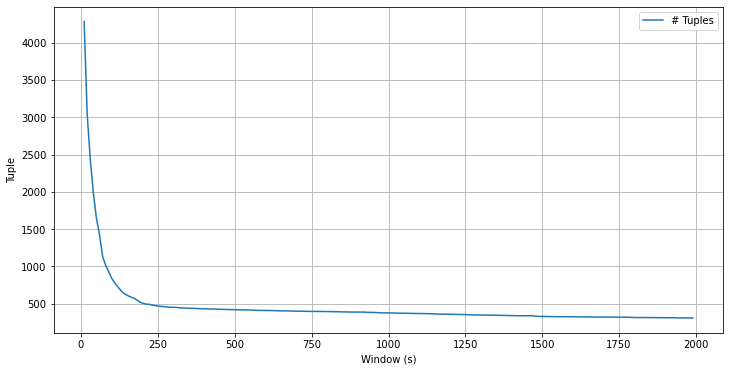

In [26]:
c_wins = np.delete(np.arange(0,2000,10), 0)

filepath = './Mercury-Sensitivity.csv'

df_mercury_sensitivity = sensitivity_analysis(df_mercury, c_wins, filepath)

plt.figure(figsize=(12,6))
plt.plot(df_mercury_sensitivity['Window'],df_mercury_sensitivity['Tuples'], label = '# Tuples')
plt.xlabel('Window (s)')
plt.ylabel('Tuple')
plt.legend()
plt.grid()
plt.savefig("./Mercury_System_Sensitivity.png", format = "png")
plt.show()

In [27]:
window = 200

filepath = './Mercury-Data.csv'

df_mercury = tupling(df_mercury, window, filepath)
df_mercury = df_mercury.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_mercury.tail()

File already exists!



,Timestamp,Node,Subsystem,Message,Type,Tuple
80849,1174943008,tg-c196,I-O,hda: packet command error: error=x,computation,506
80850,1174943068,tg-c128,I-O,hda: packet command error: error=x,computation,506
80851,1174943068,tg-c128,I-O,hda: packet command error: error=x,computation,506
80852,1174943925,tg-c196,NET,connection down,computation,507
80853,1174943943,tg-c196,I-O,hda: packet command error: error=x,computation,507


In [28]:
num_tuple = df_mercury.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)


Number of tuples:  508


In [29]:
df_sys_stat = statistics(df_mercury)
df_sys_stat.head()


,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,6,1167637660,1167637720,60,0.1,NaN
1,3,1167655228,1167655229,1,3,17508
2,61,1167657137,1167657302,165,0.369697,1908
3,14,1167657550,1167657550,0,inf,248
4,2,1167657941,1167657941,0,inf,391


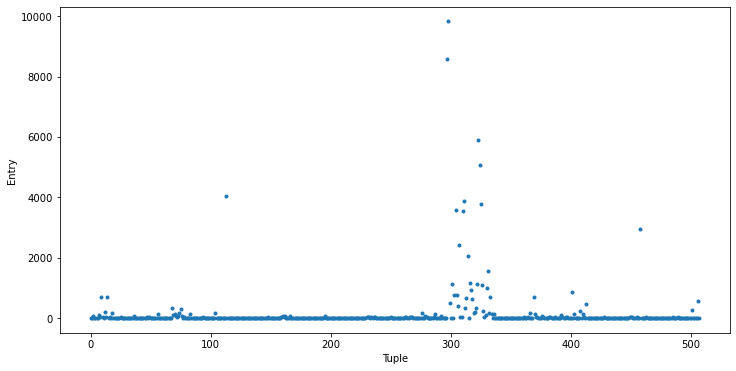

In [30]:
x = df_sys_stat.index
y = df_sys_stat['# Entries']

plt.figure(figsize=(12,6))
plt.scatter(x, y, marker = '.')
plt.xlabel('Tuple')
plt.ylabel('Entry')

plt.savefig("./Mercury_System_Scatter_Tuple_Entry.png", format = "png")
plt.show()

In [31]:
start_tup = 298
end_tup = 330
df_bottleneck = df_mercury.loc[(df_mercury['Tuple']>=start_tup) & (df_mercury['Tuple']<=end_tup)]
df_bottleneck.head()

,Timestamp,Node,Subsystem,Message,Type,Tuple
18752,1171337536,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,computation,298
18753,1171337536,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,298
18754,1171337536,tg-c401,DEV,Component Info: Vendor Id =x x,computation,298
18755,1171337537,tg-c401,DEV,+END HARDWARE ERROR STATE AT CPE,computation,298
18756,1171337537,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,298


In [32]:
print(df_mercury.groupby(by='Tuple').Timestamp.count().sort_values(ascending=False).loc[lambda x : x >=1500])


Tuple
298    9825
297    8590
323    5883
324    5065
113    4049
311    3884
325    3772
304    3583
310    3536
458    2938
307    2412
314    2057
331    1550
Name: Timestamp, dtype: int64


In [33]:
df_bottleneck.groupby(by='Node').Timestamp.count().sort_values(ascending=False)

Node
tg-c401      51536
tg-s176         10
tg-c106          7
tg-c407          4
tg-master        2
tg-s044          2
Name: Timestamp, dtype: int64

In [34]:
df_bottleneck = df_bottleneck.loc[(df_bottleneck['Node']=='tg-c401')]
df_bottleneck.head()

,Timestamp,Node,Subsystem,Message,Type,Tuple
18752,1171337536,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,computation,298
18753,1171337536,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,298
18754,1171337536,tg-c401,DEV,Component Info: Vendor Id =x x,computation,298
18755,1171337537,tg-c401,DEV,+END HARDWARE ERROR STATE AT CPE,computation,298
18756,1171337537,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,298


In [35]:
q = df_sys_stat['Interarrival'].quantile(q=0.1)
print("0.1 quantile: " + str(q))

0.1 quantile: 280.6


In [36]:
df_trunc = df_sys_stat.loc[df_sys_stat['Interarrival'] <= q]
df_trunc.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
3,14,1167657550,1167657550,0,inf,248
5,11,1167658201,1167658201,0,inf,260
6,16,1167658404,1167658456,52,0.307692,203
8,42,1167659488,1167659772,284,0.147887,211
9,680,1167660001,1167665307,5306,0.128157,229


In [37]:
num_trunc = df_trunc.shape[0]
perc_trunc = (num_trunc/num_tuple)*100

print('Estimate number of truncations:', num_trunc)
print('Estimate percentage of truncations:', perc_trunc)

Estimate number of truncations: 51
Estimate percentage of truncations: 10.039370078740157


In [38]:
df_group = df_mercury.groupby(by=['Tuple','Node']).count()
df_group.tail()

Timestamp  Subsystem  Message  Type
Tuple Node                                          
505   tg-master          4          4        4     4
506   tg-c128            2          2        2     2
      tg-c196            2          2        2     2
      tg-master        558        558      558   558
507   tg-c196            2          2        2     2

In [39]:
df_group = df_group.reset_index(level = 1)

In [40]:
collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1


In [41]:
perc_coll = (collided/num_tuple)*100

print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)


Estimate number of collisions: 47
Estimate percentage of collisions:  9.251968503937007


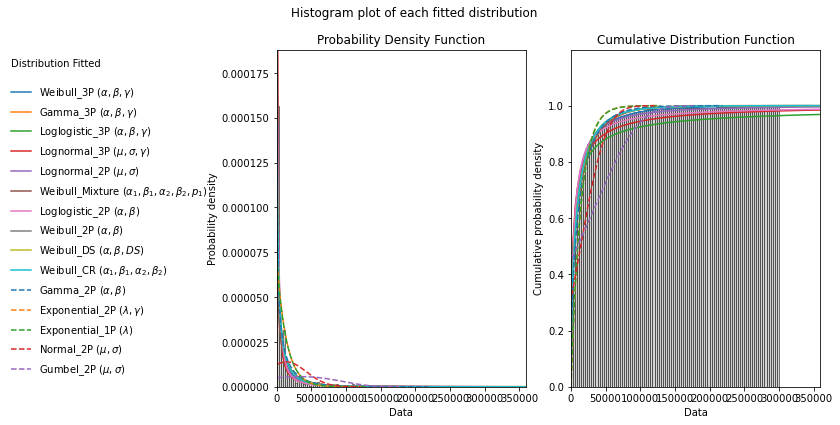

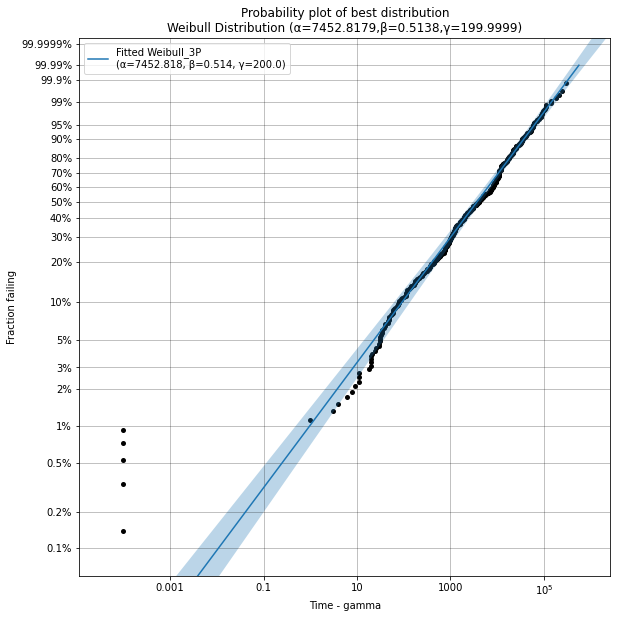

The best fitting distribution was Weibull_3P which had parameters [7.45281787e+03 5.13823532e-01 1.99999900e+02]


In [42]:
data = df_sys_stat['Interarrival'].dropna().to_numpy()

results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True)
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

In [43]:
results.results

,Distribution,Alpha,Beta,Gamma,...,AICc,BIC,AD,optimizer
0,Weibull_3P,7452.82,0.513824,200,...,10168.1,10180.7,0.85867,TNC
0,Gamma_3P,36946.4,0.375038,200,...,10180.8,10193.4,2.3973,TNC
0,Loglogistic_3P,3126.39,0.722743,200,...,10251.3,10263.9,4.79406,TNC
0,Lognormal_3P,,,195.965,...,10277.4,10290,5.65395,TNC
0,Lognormal_2P,,,,...,10354,10362.5,4.02464,TNC
0,Weibull_Mixture,,,,...,10353.5,10374.6,2.30023,TNC
0,Loglogistic_2P,3789.16,0.953596,,...,10391.2,10399.7,4.80067,TNC
0,Weibull_2P,8962.69,0.608045,,...,10403.9,10412.3,4.7201,TNC
0,Weibull_DS,8962.7,0.608045,,...,10405.9,10418.5,4.7201,TNC
0,Weibull_CR,,,,...,10407.9,10424.8,4.72012,TNC


In [44]:
results.results.columns

Index(['Distribution', 'Alpha', 'Beta', 'Gamma', 'Alpha 1', 'Beta 1', 'Alpha 2', 'Beta 2', 'Proportion 1', 'DS', 'Mu', 'Sigma', 'Lambda', 'Log-likelihood', 'AICc', 'BIC', 'AD', 'optimizer'], dtype='object')

In [45]:
results.results.loc[results.results['Distribution']=='Lognormal_2P','Gamma']

0    
Name: Gamma, dtype: object

Results from Kolmogorov-Smirnov test:
Kolmogorov-Smirnov statistic: 0.09430579703522587
Kolmogorov-Smirnov critical value: 0.05991765277635026
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=8962.6933,β=0.608)


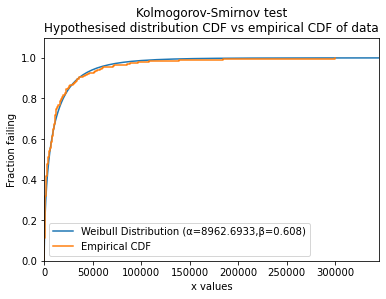

In [46]:
results.results = results.results.set_index('Distribution')
alpha = results.results.loc['Weibull_2P','Alpha']
beta = results.results.loc['Weibull_2P','Beta']


dist = Weibull_Distribution(alpha=alpha, beta=beta)

result = KStest(distribution = dist, data = df_sys_stat['Interarrival'].to_numpy(), significance = 0.05)


Results from Kolmogorov-Smirnov test:
Kolmogorov-Smirnov statistic: 0.050320980528452464
Kolmogorov-Smirnov critical value: 0.05991765277635026
At the 0.05 significance level, we can ACCEPT the hypothesis that the data comes from a Weibull Distribution (α=7452.8179,β=0.5138,γ=199.9999)


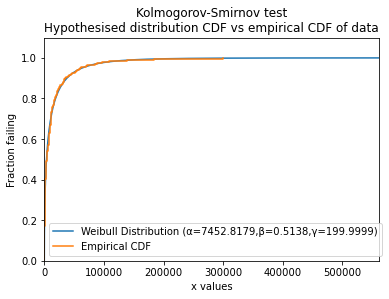

In [47]:
#results.results = results.results.set_index('Distribution')
alpha = results.results.loc['Weibull_3P','Alpha']
beta = results.results.loc['Weibull_3P','Beta']
gamma = results.results.loc['Weibull_3P','Gamma']


dist = Weibull_Distribution(alpha=alpha, beta=beta, gamma=gamma)

result = KStest(distribution = dist, data = df_sys_stat['Interarrival'].to_numpy(), significance = 0.05)

Results from Kolmogorov-Smirnov test:
Kolmogorov-Smirnov statistic: 0.07552082897799506
Kolmogorov-Smirnov critical value: 0.05991765277635026
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=8.2281,σ=1.7509)


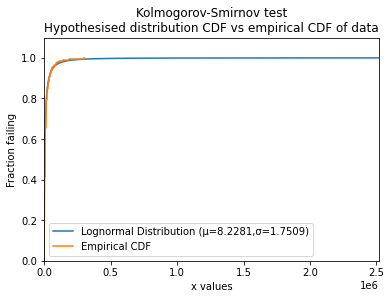

In [92]:
Mu = results.results.loc['Lognormal_2P','Mu']
Sigma = results.results.loc['Lognormal_2P','Sigma']

dist1 = Lognormal_Distribution(mu=Mu, sigma=Sigma)

result1 = KStest(distribution = dist1, data = df_sys_stat['Interarrival'].to_numpy(), significance = 0.05)

In [66]:
l = df_sys_stat['Interarrival'].to_list()
with open(r'inter.txt', 'w') as fp:
    fp.write('\n'.join(map(str, l)))



Results from Kolmogorov-Smirnov test:
Kolmogorov-Smirnov statistic: 0.2780966933447634
Kolmogorov-Smirnov critical value: 0.05991765277635026
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=7.217e-05,γ=199.9999)


AndersonResult(statistic=nan, critical_values=array([0.921, 1.077, 1.339, 1.604, 1.955]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

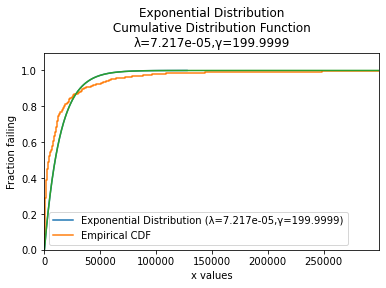

In [61]:
Lambda = results.results.loc['Exponential_2P','Lambda']
Gamma = results.results.loc['Exponential_2P','Gamma']

dist2 = Exponential_Distribution(Lambda=Lambda, gamma=Gamma)

result2 = KStest(distribution = dist2, data = df_sys_stat['Interarrival'].to_numpy(), significance = 0.05)

scipy.stats.cramervonmises(df_sys_stat['Interarrival'].to_numpy(), dist2.CDF)
scipy.stats.anderson(df_sys_stat['Interarrival'].to_numpy(), 'expon')


TypeError: 'Exponential_Distribution' object is not callable